In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F
import statistics

In [0]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
epochs = 50
batch_size = 64
classes = ('tshirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot')

In [0]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ])
train_val_dataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)
ratio = 0.2
train_examples = int((1.0-ratio)*len(train_val_dataset))
val_examples = int(ratio*len(train_val_dataset))
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_val_dataset,[train_examples,val_examples])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [0]:
def plot_graph(training_losses,val_losses,epochs,string):
    plt.figure()
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.title(string + 'per epoch')
    plt.xlabel('Epoch')
    plt.ylabel(string)

# Classifier

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(3136, 500)
        self.fc1_drop = nn.Dropout2d(p=0.3)
        self.fc2 = nn.Linear(500,50)
        self.fc2_drop = nn.Dropout2d(p=0.3)
        self.fc3 = nn.Linear(50,10)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x),2))
        x = F.leaky_relu(F.max_pool2d(self.conv2(x),2))
        x = x.view(x.size(0),-1)
        x = F.leaky_relu(self.fc1_drop(self.fc1(x)))
        x = F.leaky_relu(self.fc2_drop(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(model,device,optimizer,epoch,trainloader,criterion):
    model.train()
    epoch_loss = 0
    correct = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(trainloader.dataset),
        100. * correct / len(trainloader.dataset)))
    return epoch_loss, 100. * correct / len(trainloader.dataset)
    
def test(model,device,testloader,criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output,labels)
            epoch_loss += loss.item()
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average test loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss, 100. * correct / len(testloader.dataset)



In [0]:
model = Classifier().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
training_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    print("Epoch", epoch)
    train_loss, train_accuracy = train(model,device,optimizer,epoch,trainloader,criterion)
    val_loss, val_accuracy = test(model,device,valloader,criterion)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 0
Average training loss: 0.9179, Training Accuracy: 30090/45000 (67%)
Average test loss: 0.4646, Testing Accuracy: 12335/15000 (82%)
Epoch 1
Average training loss: 0.5333, Training Accuracy: 36216/45000 (80%)
Average test loss: 0.3970, Testing Accuracy: 12716/15000 (85%)
Epoch 2
Average training loss: 0.4578, Training Accuracy: 37717/45000 (84%)
Average test loss: 0.3710, Testing Accuracy: 13076/15000 (87%)
Epoch 3
Average training loss: 0.4165, Training Accuracy: 38518/45000 (86%)
Average test loss: 0.3265, Testing Accuracy: 13187/15000 (88%)
Epoch 4
Average training loss: 0.3946, Training Accuracy: 38933/45000 (87%)
Average test loss: 0.3474, Testing Accuracy: 13109/15000 (87%)
Epoch 5
Average training loss: 0.3749, Training Accuracy: 39083/45000 (87%)
Average test loss: 0.2988, Testing Accuracy: 13404/15000 (89%)
Epoch 6
Average training loss: 0.3580, Training Accuracy: 39463/45000 (88%)
Average test loss: 0.3769, Testing Accuracy: 13127/15000 (88%)
Epoch 7
Average training lo

Average test loss: 0.3277, Testing Accuracy: 8950/10000 (90%)
Lowest validation loss 0.2817957316624357
Lowest training loss 0.25138567530401895


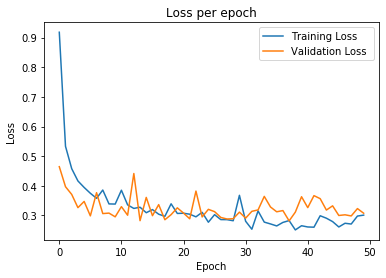

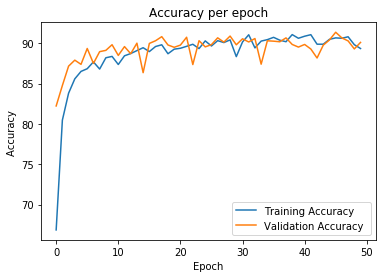

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
test(model,device,testloader,criterion)
print("Lowest validation loss", min(val_losses))
print("Lowest training loss", min(training_losses))

# Autoencoder

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.MaxPool2d(2, 2),
            nn.LeakyReLU(),

            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.MaxPool2d(2, 2),
            #nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
def train(model,device,optimizer,epoch,trainloader,criterion):
    model.train()
    epoch_loss = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,images)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print("Average training loss:",epoch_loss)
    return epoch_loss
    
def test(model,device,testloader,criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output,images)
            epoch_loss += loss.item()
    epoch_loss /= len(testloader)
    print('Average testing loss: {:.4f}'.format(epoch_loss))
    return epoch_loss



In [0]:
model = AutoEncoder().to(device)
#optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
training_losses = []
val_losses = []
for epoch in range(epochs):
    print("Epoch", epoch)
    train_loss = train(model,device,optimizer,epoch,trainloader,criterion)
    val_loss = test(model,device,valloader,criterion)
    training_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch 0
Average training loss: 0.006368490019336936
Average testing loss: 0.0039
Epoch 1
Average training loss: 0.0035052691531415226
Average testing loss: 0.0051
Epoch 2
Average training loss: 0.0030850435148088514
Average testing loss: 0.0052
Epoch 3
Average training loss: 0.002853798284294581
Average testing loss: 0.0028
Epoch 4
Average training loss: 0.0027212404354279647
Average testing loss: 0.0030
Epoch 5
Average training loss: 0.0026378436151307224
Average testing loss: 0.0027
Epoch 6
Average training loss: 0.002585141302419784
Average testing loss: 0.0023
Epoch 7
Average training loss: 0.0024901450866640184
Average testing loss: 0.0028
Epoch 8
Average training loss: 0.00241208103216195
Average testing loss: 0.0025
Epoch 9
Average training loss: 0.002356897379286238
Average testing loss: 0.0023
Epoch 10
Average training loss: 0.002308230222380106
Average testing loss: 0.0071
Epoch 11
Average training loss: 0.002330544347139287
Average testing loss: 0.0028
Epoch 12
Average train

Average testing loss: 0.0019
Lowest validation loss 0.0018553900056855475


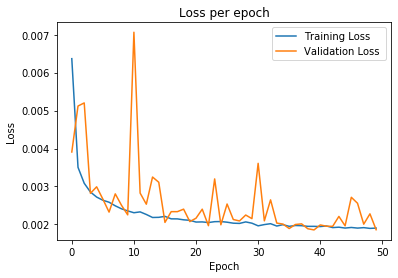

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
test(model,device,testloader,criterion)
print("Lowest validation loss", min(val_losses))

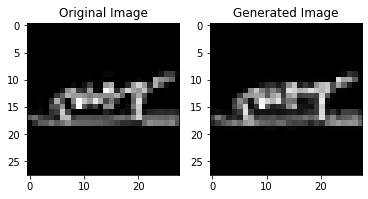

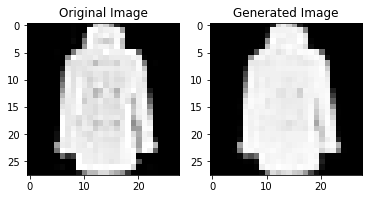

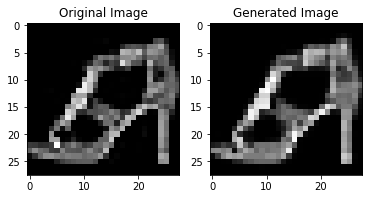

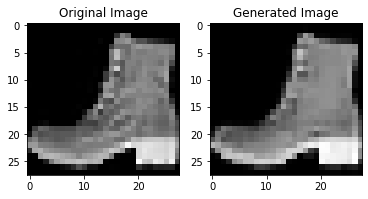

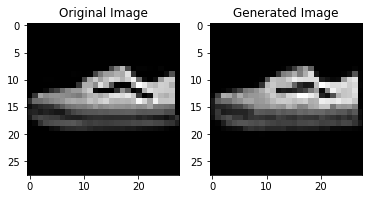

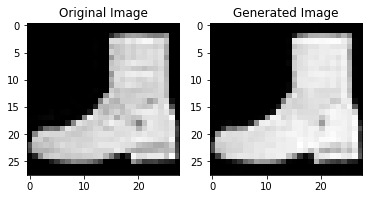

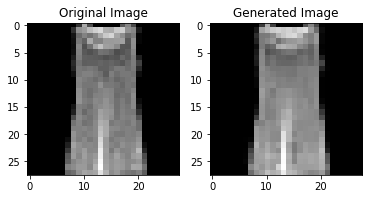

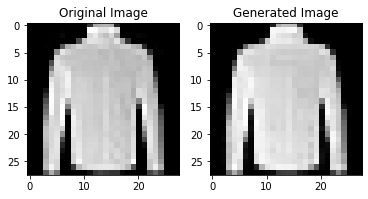

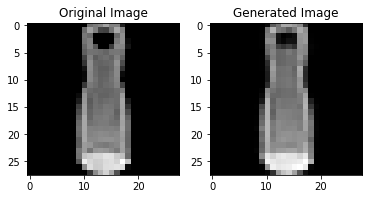

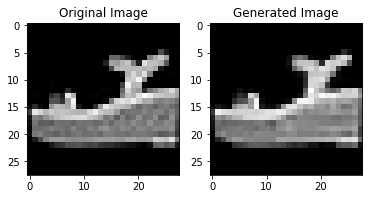

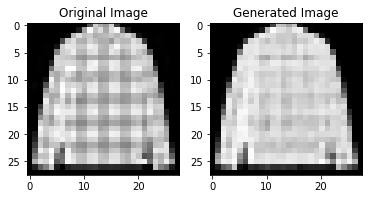

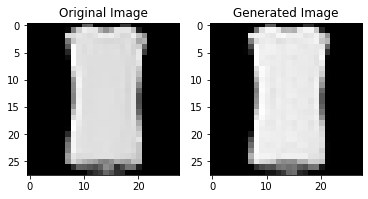

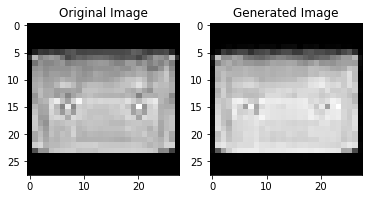

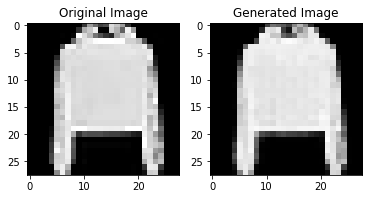

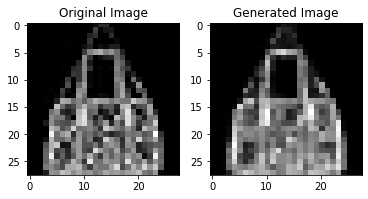

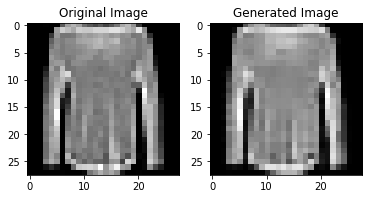

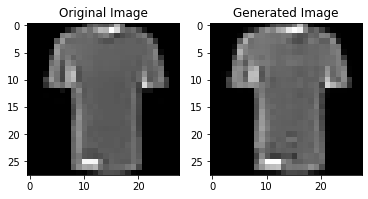

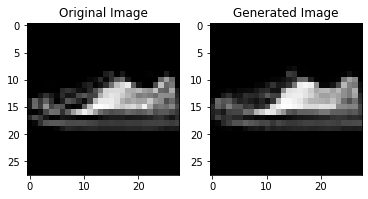

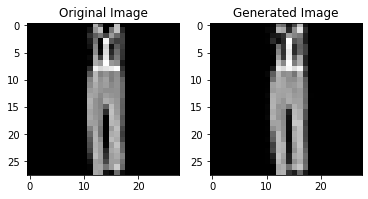

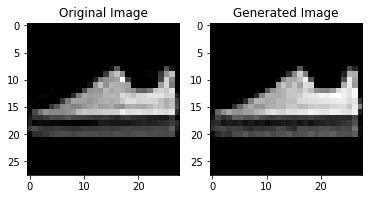

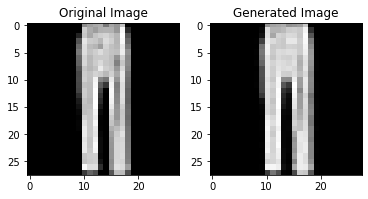

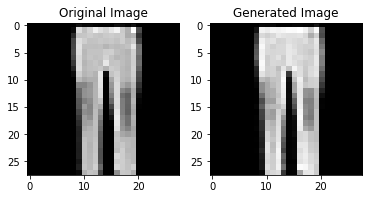

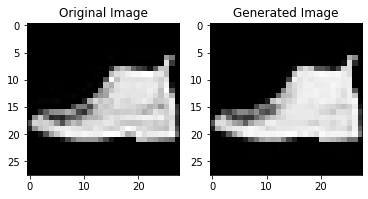

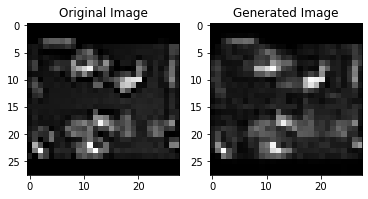

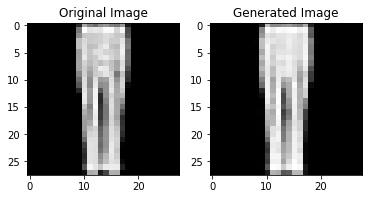

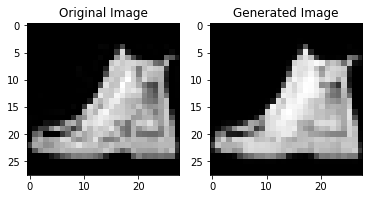

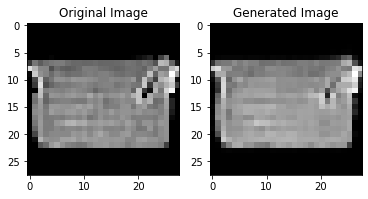

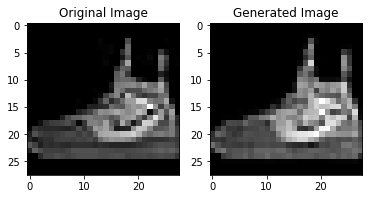

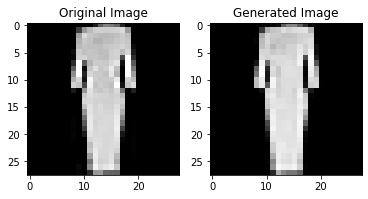

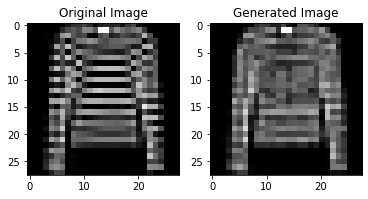

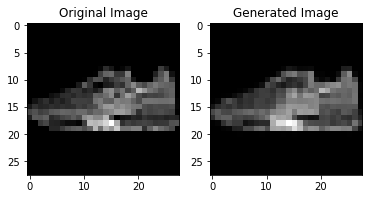

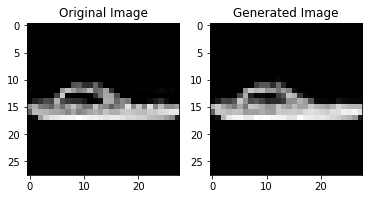

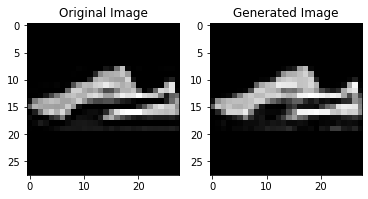

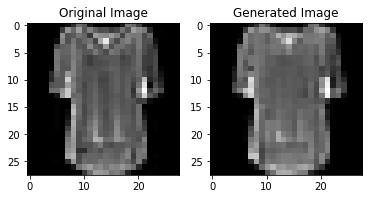

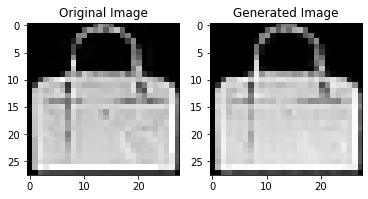

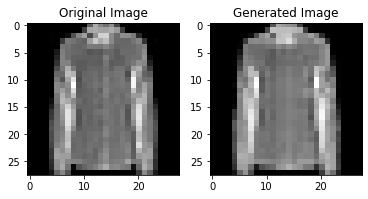

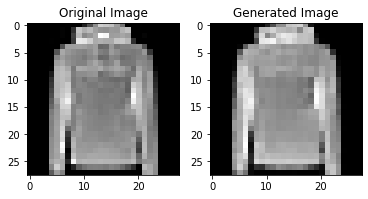

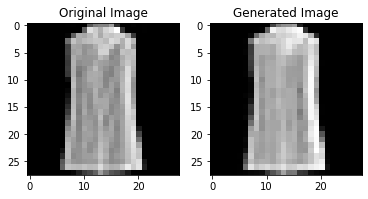

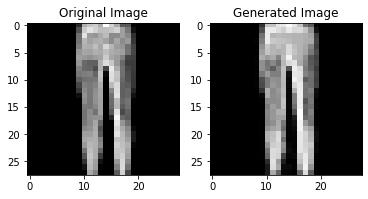

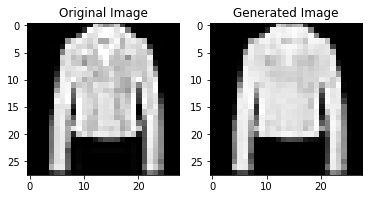

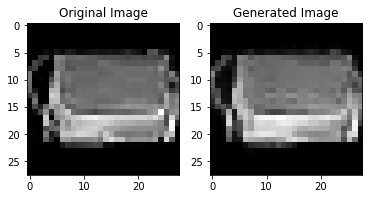

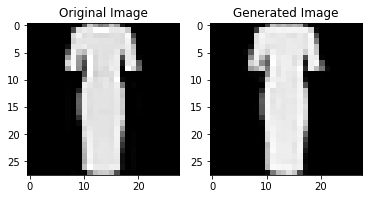

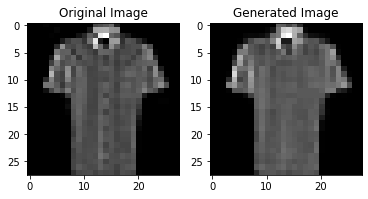

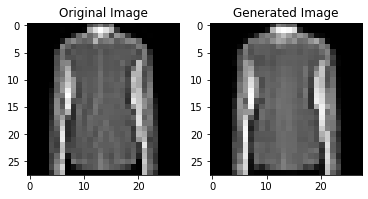

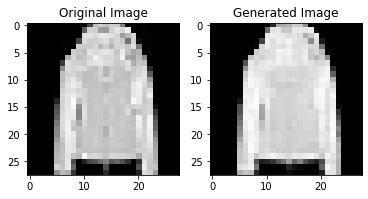

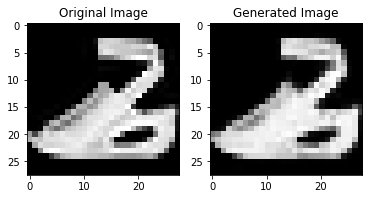

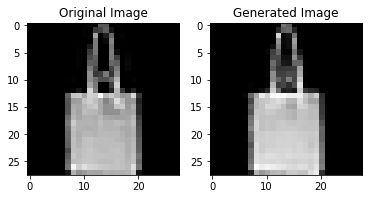

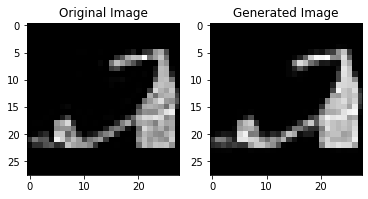

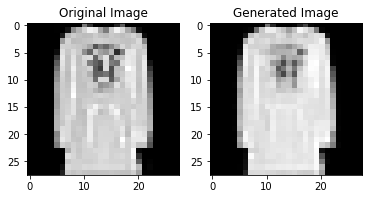

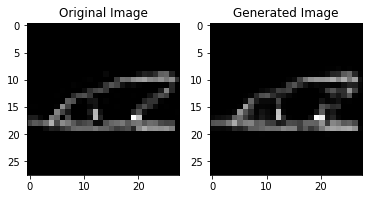

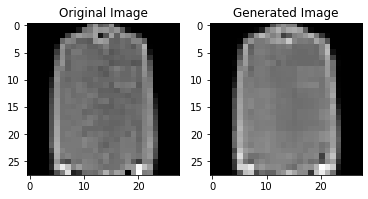

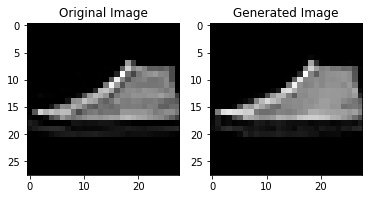

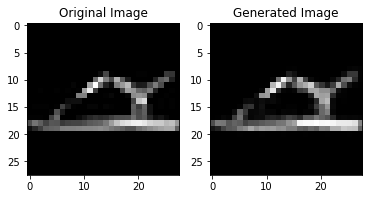

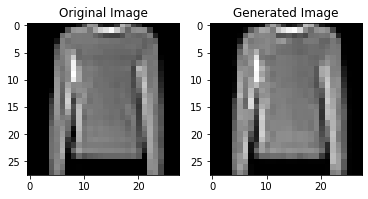

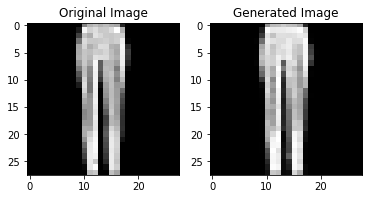

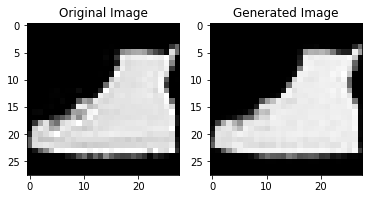

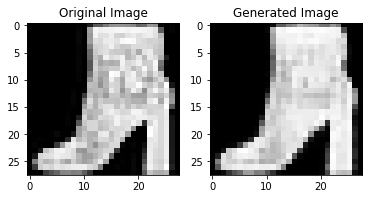

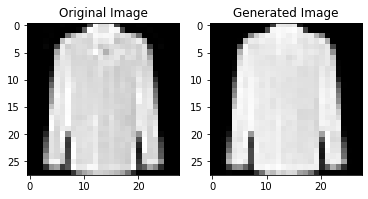

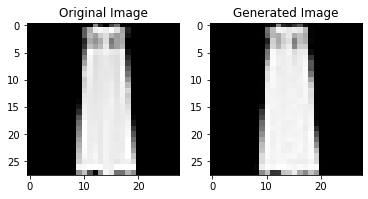

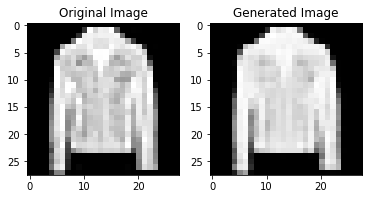

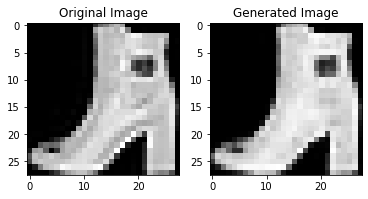

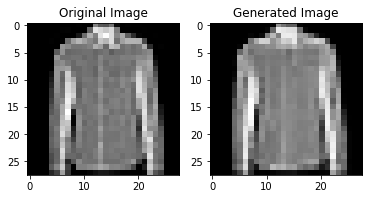

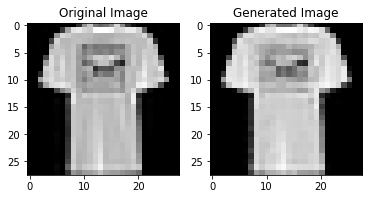

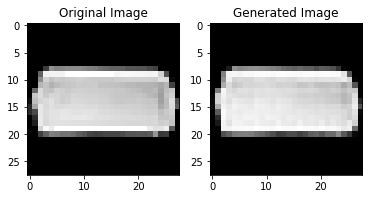

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output = model(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Mixed model definitions

In [0]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.LeakyReLU(),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(3136,500),
            nn.Dropout(p=0.3),
            nn.LeakyReLU(),
  
            nn.Linear(500,50),
            nn.Dropout(p=0.3),
            nn.LeakyReLU(),

            nn.Linear(50,10),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        encoded = encoded.view(encoded.size(0),-1)
        predicted = self.classifier(encoded)
        return decoded, predicted

# Mixed (autoencoder loss)

In [0]:
def train(model,device,optimizer,epoch,trainloader):
    model.train()
    epoch_loss = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        decoded,predicted = model(images)
        criterion1 = nn.MSELoss()
        criterion2 = nn.CrossEntropyLoss()
        loss = criterion1(decoded,images)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print("Average training loss:",epoch_loss)
    return epoch_loss
    
def test(model,device,testloader):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            decoded, predicted = model(images)
            criterion1 = nn.MSELoss()
            criterion2 = nn.CrossEntropyLoss()
            loss = criterion1(decoded,images)
            epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss

In [0]:
model = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.01)
training_losses = []
val_losses = []
for epoch in range(epochs):
    print("Epoch", epoch)
    train_loss = train(model,device,optimizer,epoch,trainloader)
    val_loss = test(model,device,valloader)
    training_losses.append(train_loss)
    val_losses.append(val_loss)


Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average training loss: 0.006022599514174296
Average loss: 0.0048, Testing Accuracy: 2379/15000 (16%)
Epoch 1
Average training loss: 0.003183256148490314
Average loss: 0.0058, Testing Accuracy: 1823/15000 (12%)
Epoch 2
Average training loss: 0.0027099494248184123
Average loss: 0.0024, Testing Accuracy: 1761/15000 (12%)
Epoch 3
Average training loss: 0.0025158146256051787
Average loss: 0.0025, Testing Accuracy: 1640/15000 (11%)
Epoch 4
Average training loss: 0.0023521143177111462
Average loss: 0.0031, Testing Accuracy: 1602/15000 (11%)
Epoch 5
Average training loss: 0.0023006651650079716
Average loss: 0.0026, Testing Accuracy: 1489/15000 (10%)
Epoch 6
Average training loss: 0.00223141279506804
Average loss: 0.0027, Testing Accuracy: 1603/15000 (11%)
Epoch 7
Average training loss: 0.0021386926271754255
Average loss: 0.0029, Testing Accuracy: 1537/15000 (10%)
Epoch 8
Average training loss: 0.002106448885321945
Average loss: 0.0029, Testing Accuracy: 1501/15000 (10%)
Epoch 9
Average trainin

In [0]:
train_mean_auto = statistics.mean(training_losses)
val_mean_auto = statistics.mean(val_losses)
train_std_auto = statistics.stdev(training_losses)
val_std_auto = statistics.stdev(val_losses)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average loss: 0.0017, Testing Accuracy: 768/10000 (8%)
Lowest validation loss 0.0015893142903223635


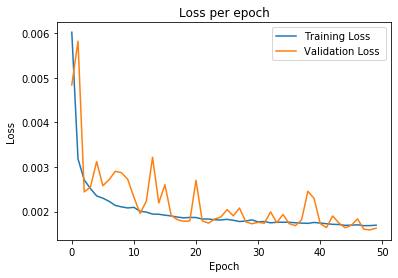

In [0]:
plot_graph(training_losses,val_losses,epochs, "Loss ")
test(model,device,testloader)
print("Lowest validation loss", min(val_losses))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


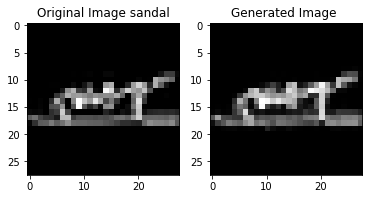

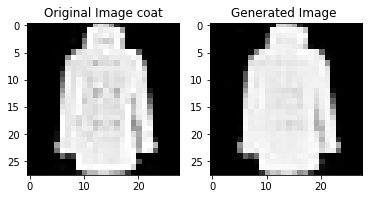

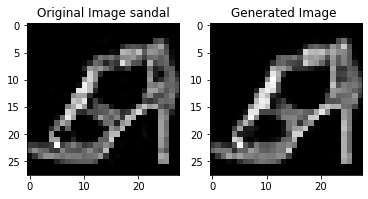

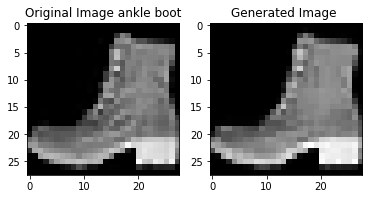

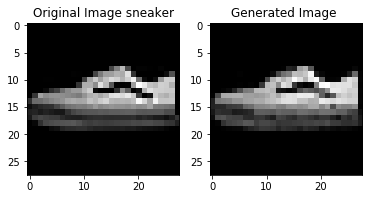

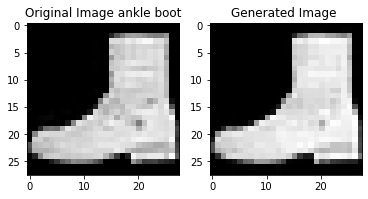

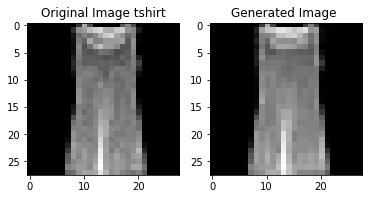

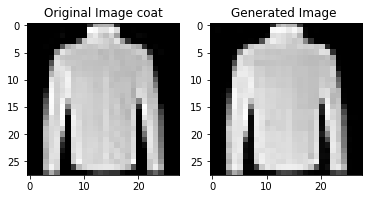

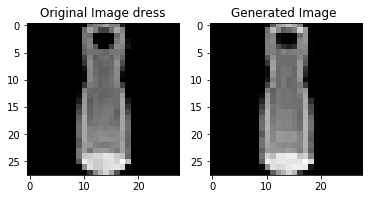

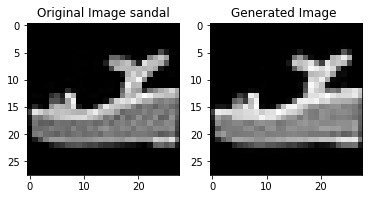

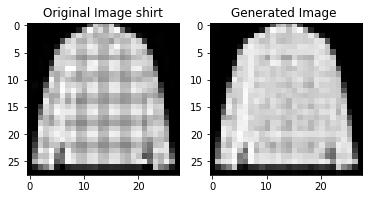

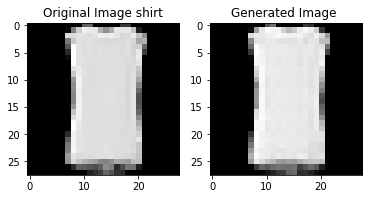

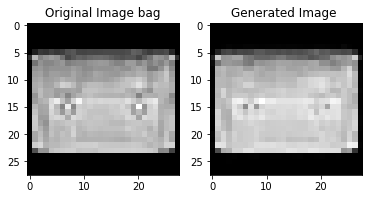

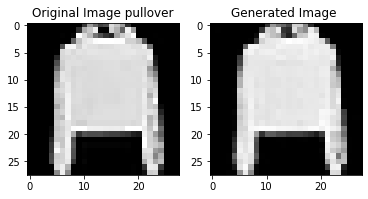

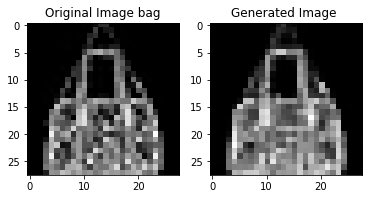

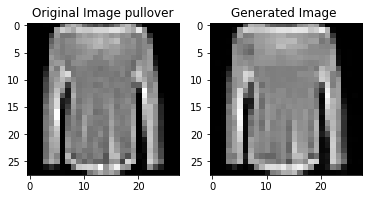

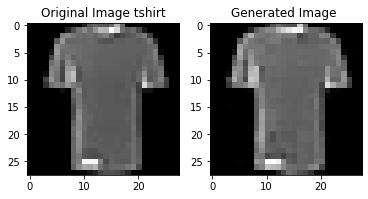

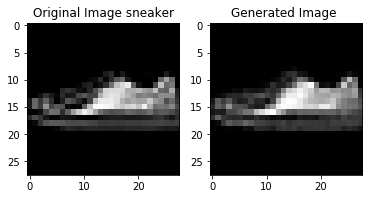

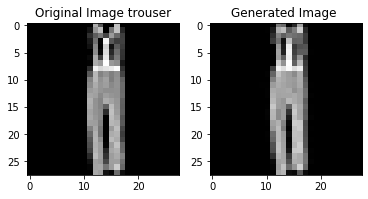

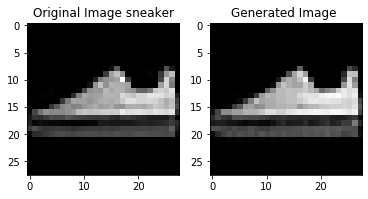

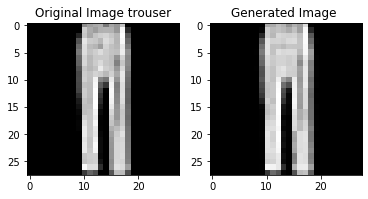

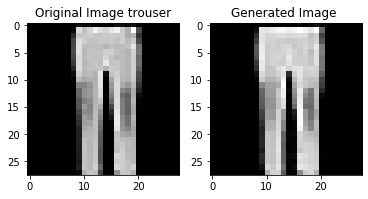

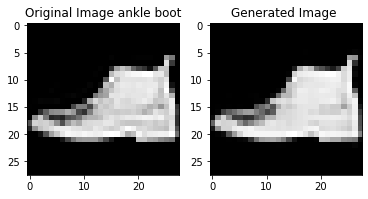

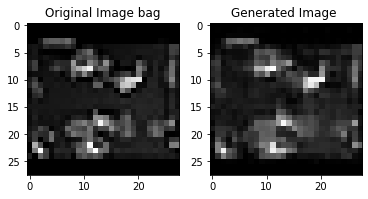

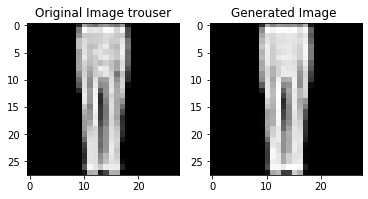

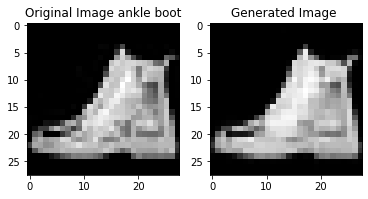

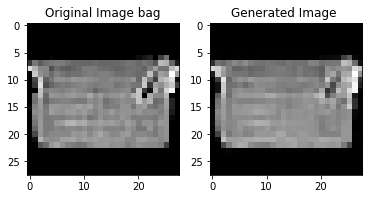

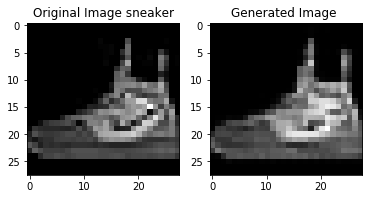

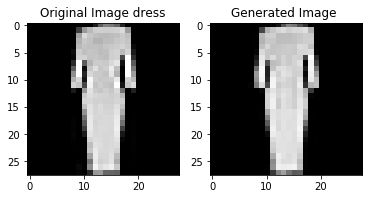

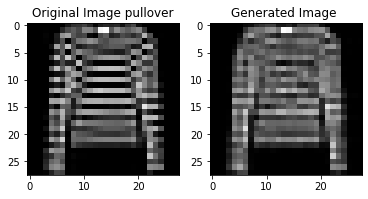

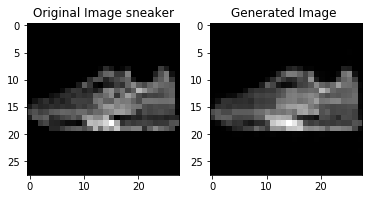

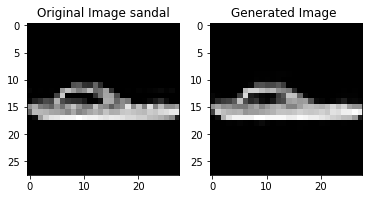

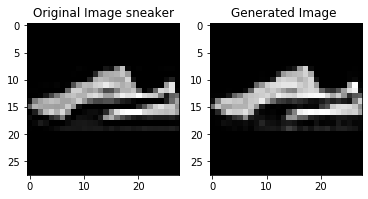

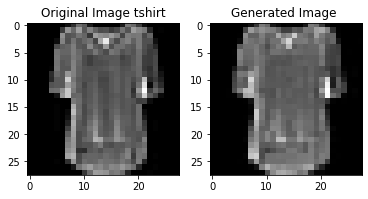

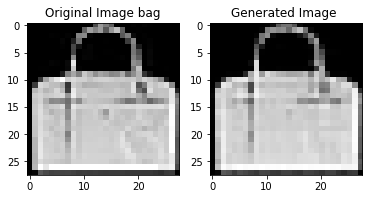

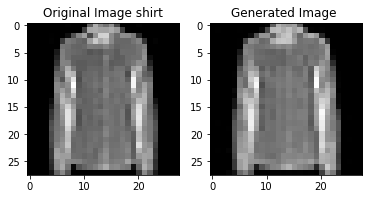

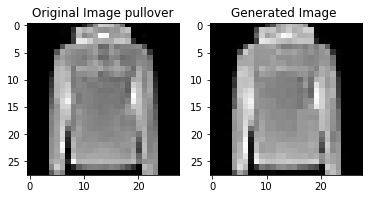

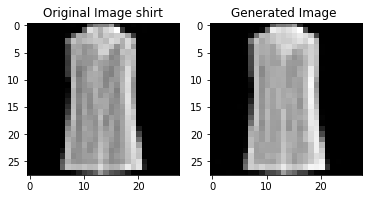

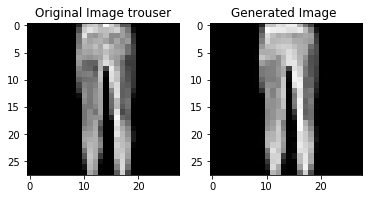

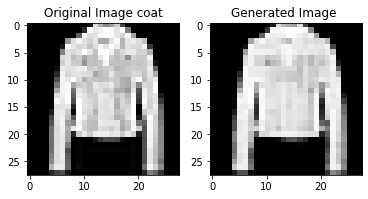

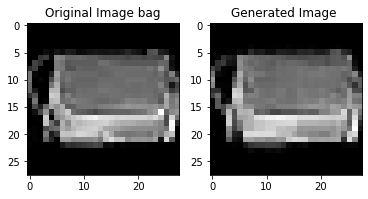

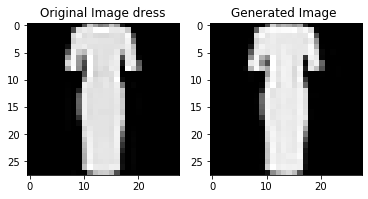

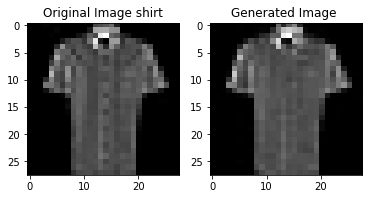

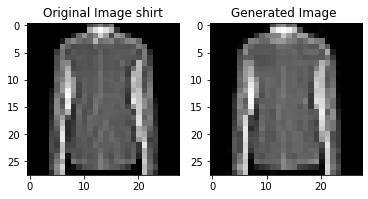

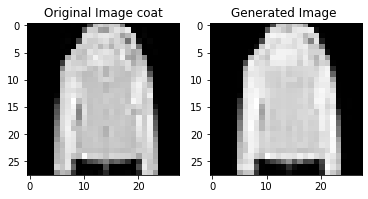

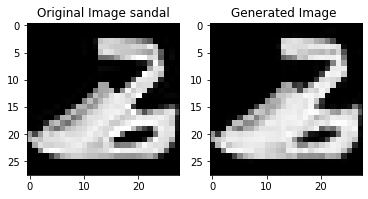

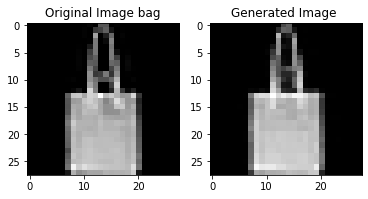

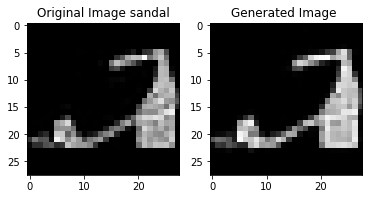

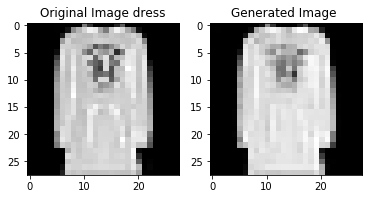

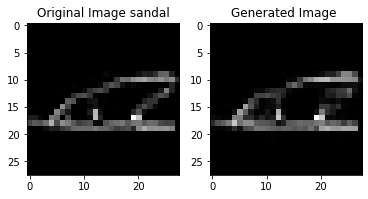

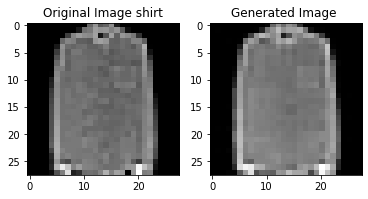

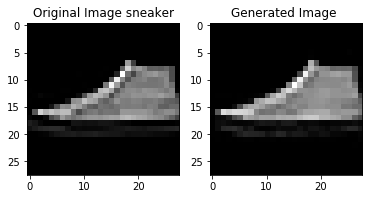

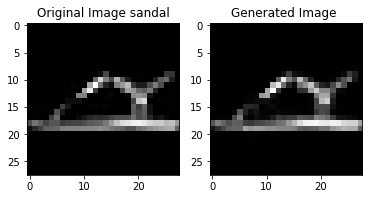

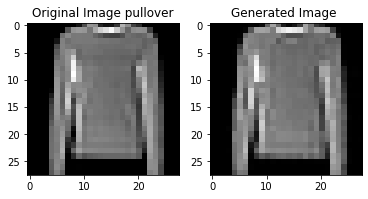

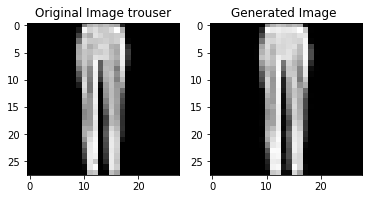

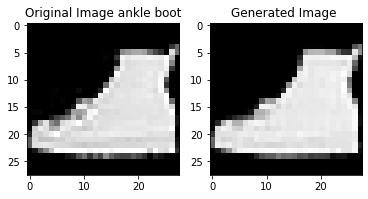

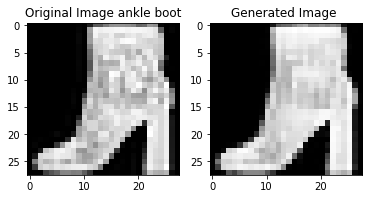

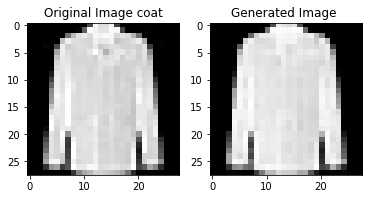

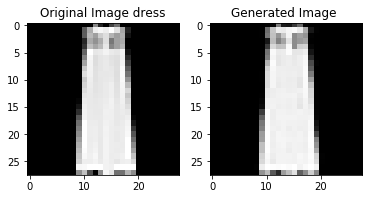

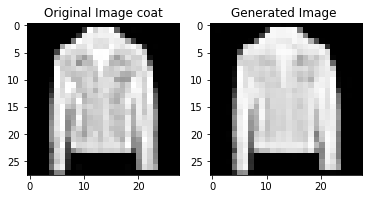

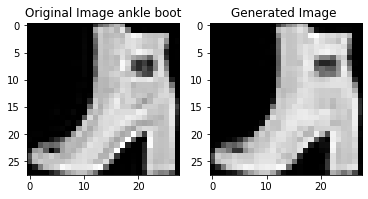

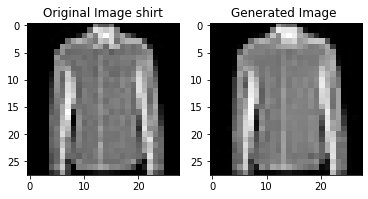

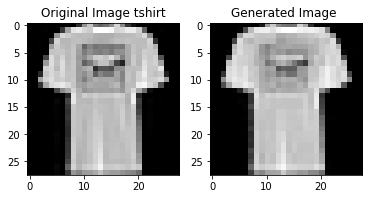

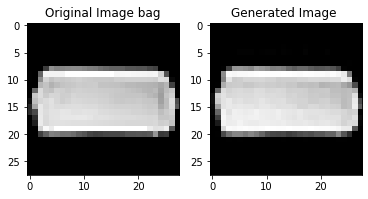

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Mixed (classifier loss)

In [0]:
def train(model,device,optimizer,epoch,trainloader):
    model.train()
    epoch_loss = 0
    correct = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        decoded,predicted = model(images)
        criterion1 = nn.MSELoss()
        criterion2 = nn.CrossEntropyLoss()
        loss = criterion2(predicted,labels)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(trainloader.dataset),
        100. * correct / len(trainloader.dataset)))
    return epoch_loss, 100. * correct / len(trainloader.dataset)
    
def test(model,device,testloader):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            decoded, predicted = model(images)
            criterion1 = nn.MSELoss()
            criterion2 = nn.CrossEntropyLoss()
            loss = criterion2(predicted,labels)
            epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average testing loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss, 100. * correct / len(testloader.dataset)

In [0]:
model = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.01)
training_losses = []
val_losses = []
training_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    print("Epoch", epoch)
    train_loss, train_accuracy = train(model,device,optimizer,epoch,trainloader)
    val_loss, val_accuracy = test(model,device,valloader)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
    training_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average training loss: 0.8430, Training Accuracy: 31440/45000 (70%)
Average testing loss: 0.5027, Testing Accuracy: 12143/15000 (81%)
Epoch 1
Average training loss: 0.5406, Training Accuracy: 36337/45000 (81%)
Average testing loss: 0.4322, Testing Accuracy: 12498/15000 (83%)
Epoch 2
Average training loss: 0.4880, Training Accuracy: 37516/45000 (83%)
Average testing loss: 0.3965, Testing Accuracy: 13049/15000 (87%)
Epoch 3
Average training loss: 0.4508, Training Accuracy: 38208/45000 (85%)
Average testing loss: 0.3289, Testing Accuracy: 13329/15000 (89%)
Epoch 4
Average training loss: 0.5031, Training Accuracy: 37685/45000 (84%)
Average testing loss: 0.3869, Testing Accuracy: 13151/15000 (88%)
Epoch 5
Average training loss: 0.4410, Training Accuracy: 38332/45000 (85%)
Average testing loss: 0.3248, Testing Accuracy: 13262/15000 (88%)
Epoch 6
Average training loss: 0.3934, Training Accuracy: 39055/45000 (87%)
Average testing loss: 0.4902, Testing Accuracy: 12579/15000 (84%)
Epoch 7
Averag

In [0]:
train_class_mean = statistics.mean(training_losses)
val_class_mean = statistics.mean(val_losses)
train_class_std = statistics.stdev(training_losses)
val_class_std = statistics.stdev(val_losses)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average testing loss: 0.3764, Testing Accuracy: 8919/10000 (89%)
Lowest validation loss 0.28679479829808496


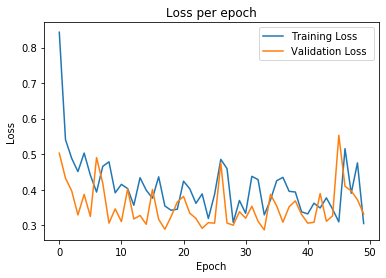

In [0]:
plot_graph(training_losses,val_losses,epochs, "Loss ")
test(model,device,testloader)
print("Lowest validation loss", min(val_losses))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


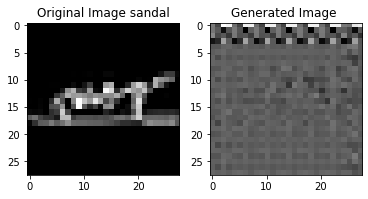

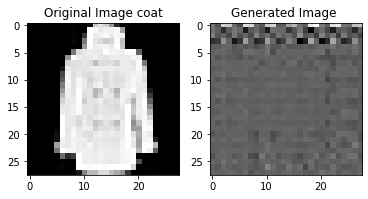

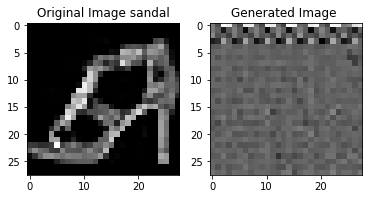

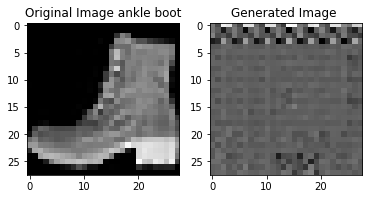

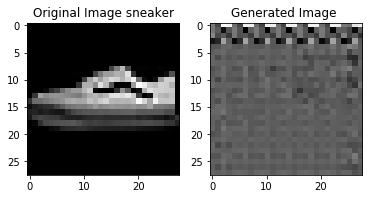

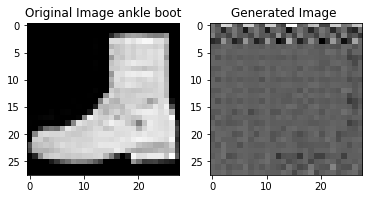

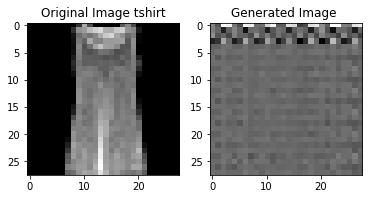

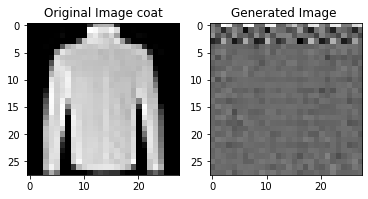

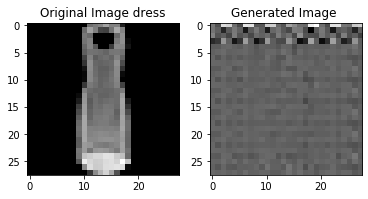

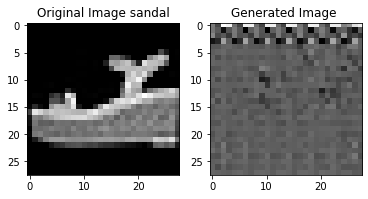

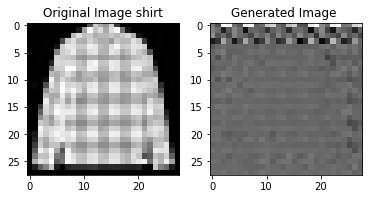

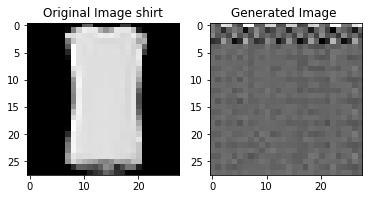

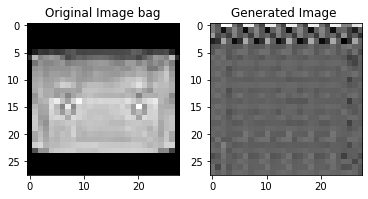

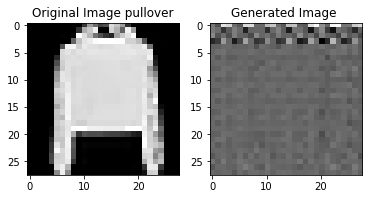

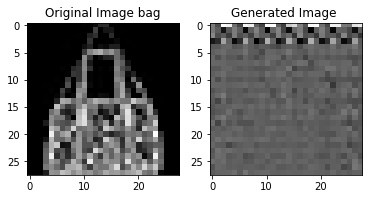

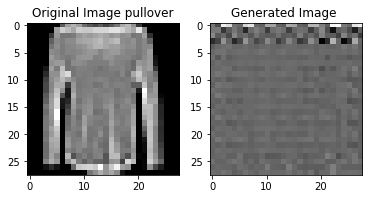

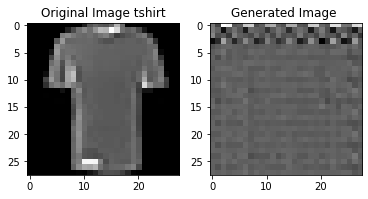

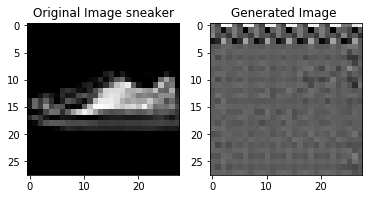

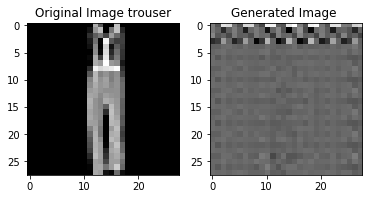

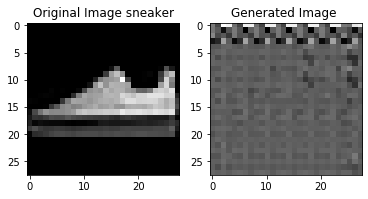

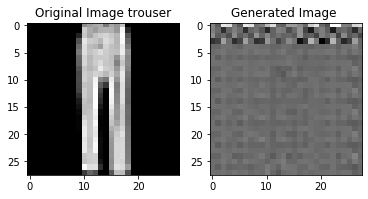

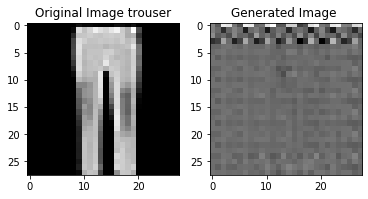

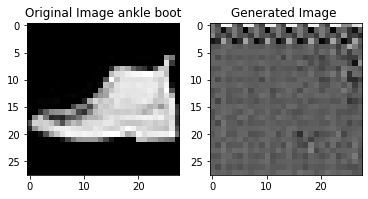

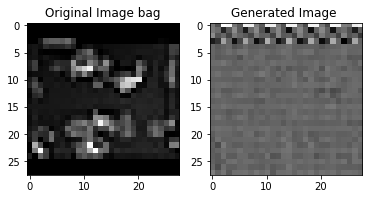

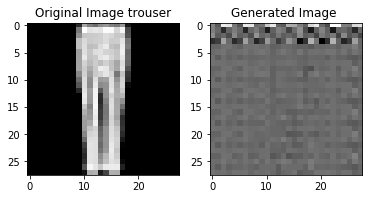

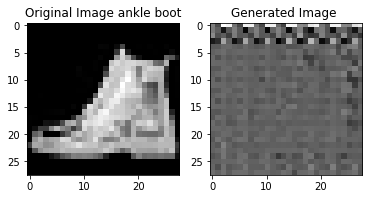

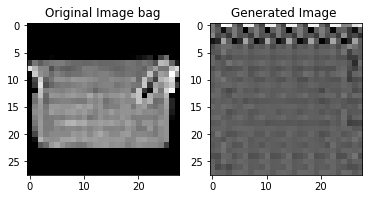

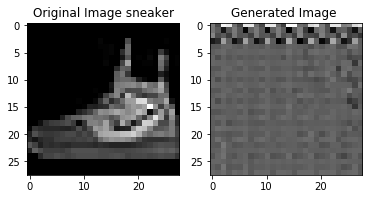

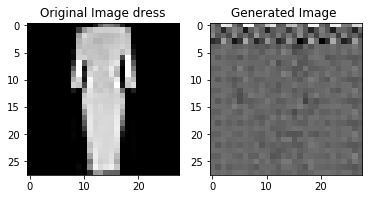

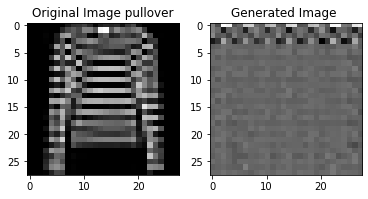

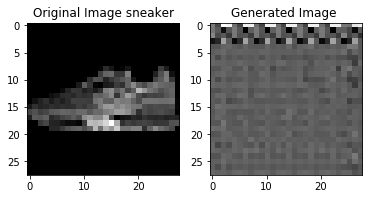

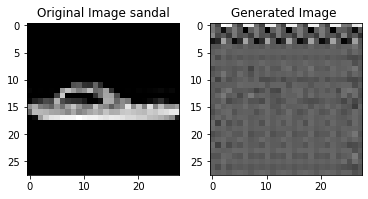

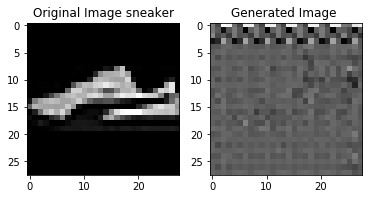

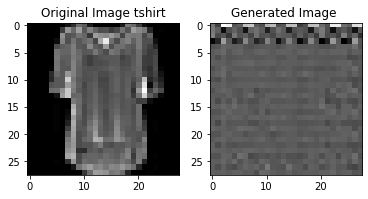

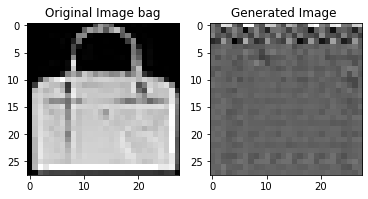

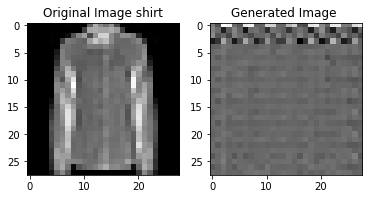

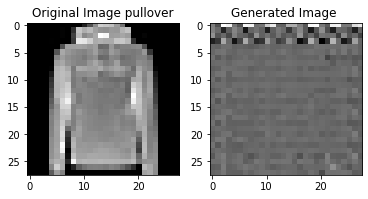

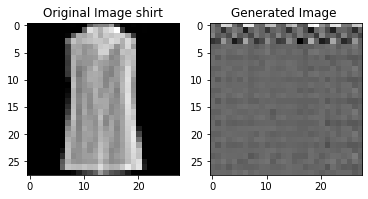

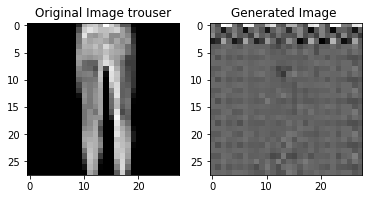

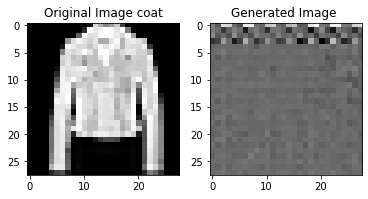

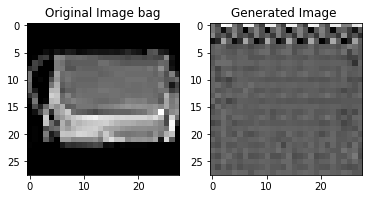

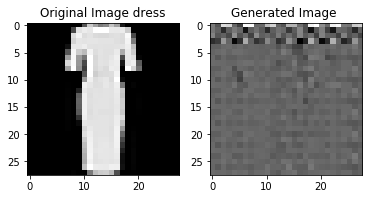

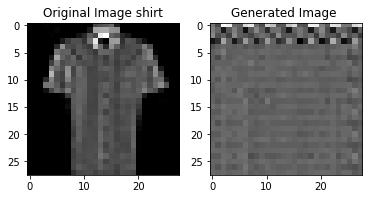

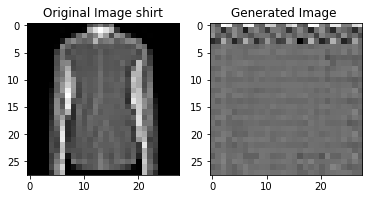

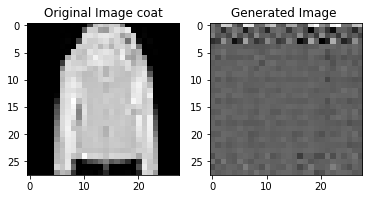

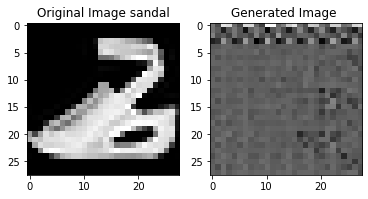

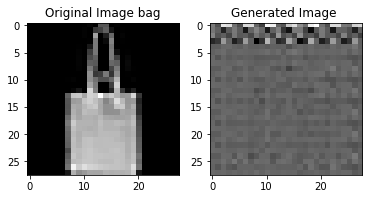

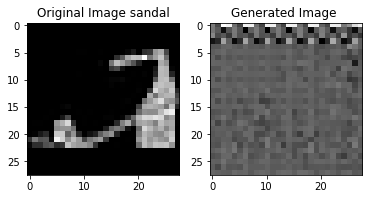

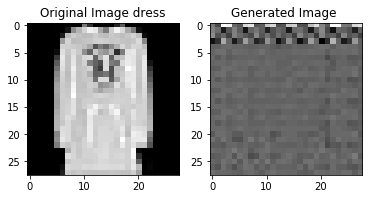

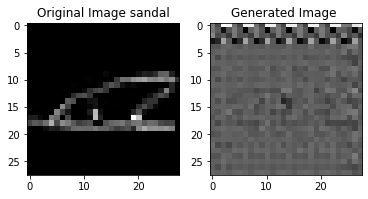

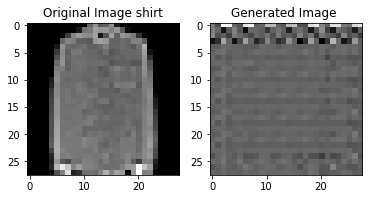

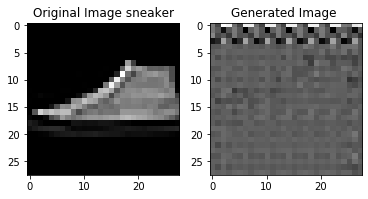

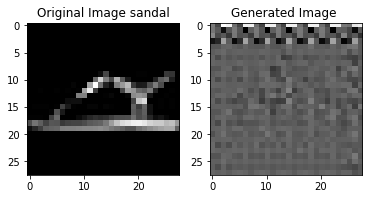

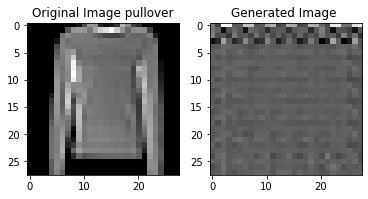

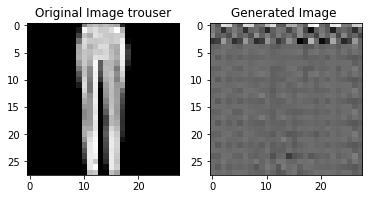

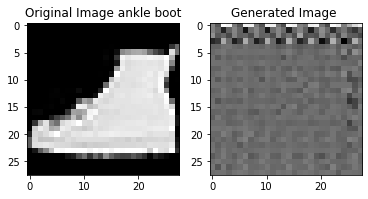

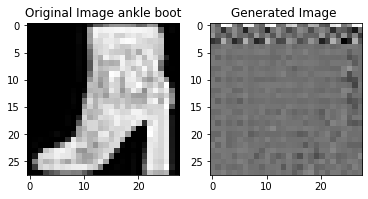

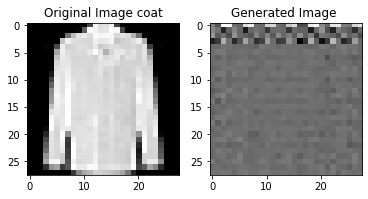

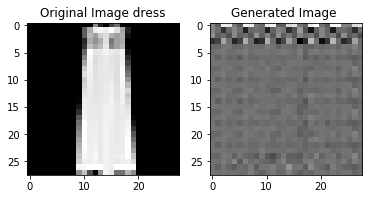

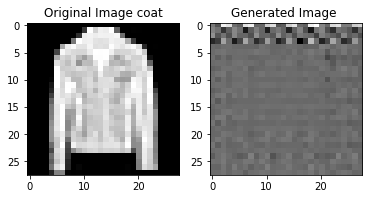

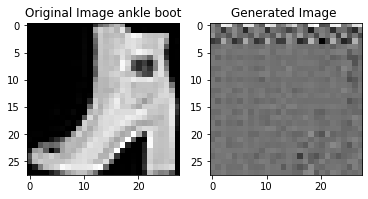

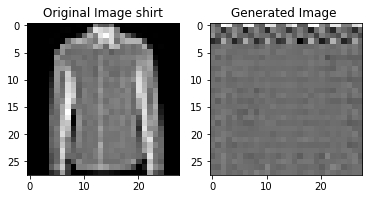

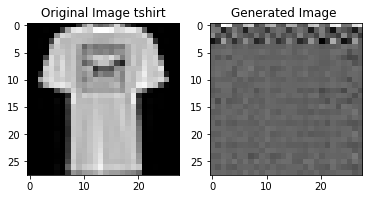

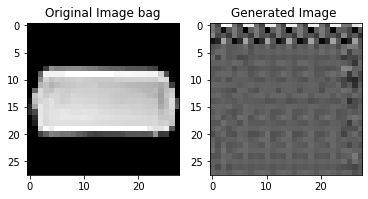

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Mixed (two losses - no scaling of losses)

In [0]:
def train(model,device,optimizer,epoch,trainloader):
    model.train()
    epoch_loss = 0
    correct = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        decoded,predicted = model(images)
        criterion1 = nn.MSELoss()
        criterion2 = nn.CrossEntropyLoss()
        loss1 = criterion1(decoded,images)
        loss2 = criterion2(predicted,labels)
        loss = loss1+loss2
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(trainloader.dataset),
        100. * correct / len(trainloader.dataset)))
    return epoch_loss, 100. * correct / len(trainloader.dataset)
    
def test(model,device,testloader):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            decoded, predicted = model(images)
            criterion1 = nn.MSELoss()
            criterion2 = nn.CrossEntropyLoss()
            loss1 = criterion1(decoded,images)
            loss2 = criterion2(predicted,labels)
            loss = loss1+loss2
            epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average test loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss, 100. * correct / len(testloader.dataset)

In [0]:
model = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.01)
training_losses = []
val_losses = []
training_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    print("Epoch", epoch)
    train_loss, train_accuracy = train(model,device,optimizer,epoch,trainloader)
    val_loss, val_accuracy = test(model,device,valloader)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
    training_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average training loss: 0.8305, Training Accuracy: 32027/45000 (71%)
Average test loss: 0.4993, Testing Accuracy: 12413/15000 (83%)
Epoch 1
Average training loss: 0.5481, Training Accuracy: 36657/45000 (81%)
Average test loss: 0.4156, Testing Accuracy: 12947/15000 (86%)
Epoch 2
Average training loss: 0.4942, Training Accuracy: 37529/45000 (83%)
Average test loss: 0.4575, Testing Accuracy: 12977/15000 (87%)
Epoch 3
Average training loss: 0.5535, Training Accuracy: 36972/45000 (82%)
Average test loss: 0.4428, Testing Accuracy: 12755/15000 (85%)
Epoch 4
Average training loss: 0.4626, Training Accuracy: 38186/45000 (85%)
Average test loss: 0.4149, Testing Accuracy: 12873/15000 (86%)
Epoch 5
Average training loss: 0.4400, Training Accuracy: 38577/45000 (86%)
Average test loss: 0.4440, Testing Accuracy: 12824/15000 (85%)
Epoch 6
Average training loss: 0.5268, Training Accuracy: 37697/45000 (84%)
Average test loss: 0.3513, Testing Accuracy: 13250/15000 (88%)
Epoch 7
Average training loss: 0.39

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average test loss: 0.4145, Testing Accuracy: 8986/10000 (90%)
Lowest validation loss 0.294951372894835


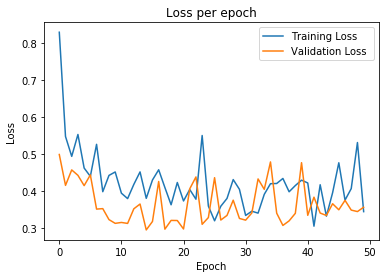

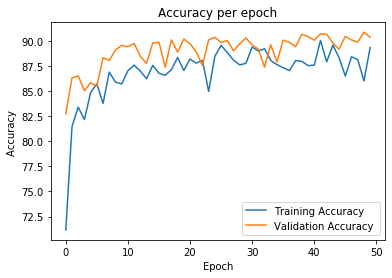

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(training_accuracies,val_accuracies,epochs,"Accuracy ")
test(model,device,testloader)
print("Lowest validation loss", min(val_losses))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


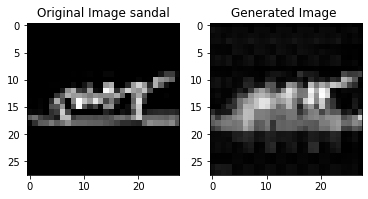

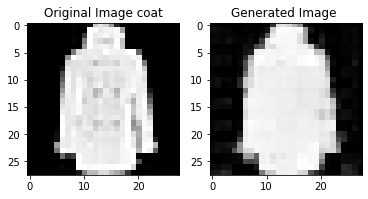

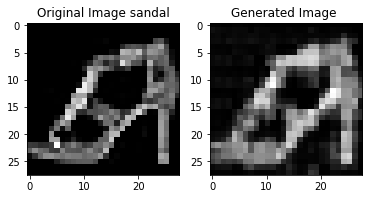

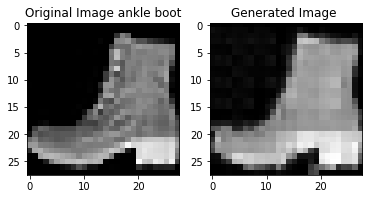

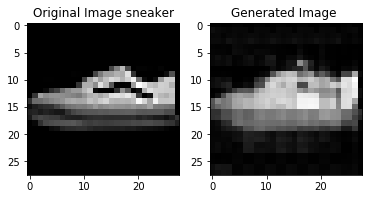

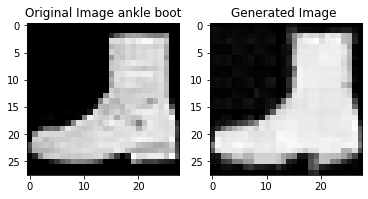

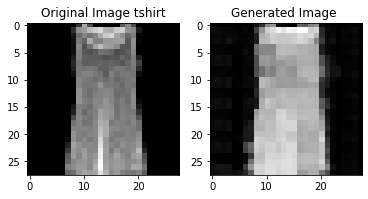

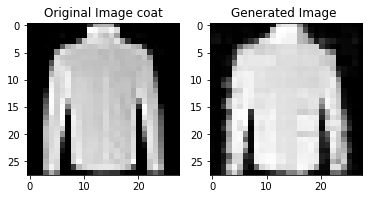

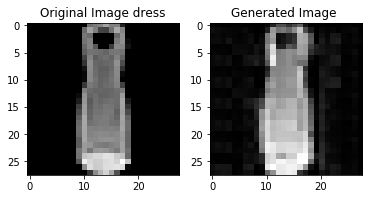

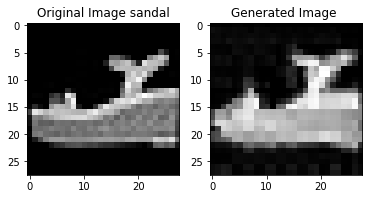

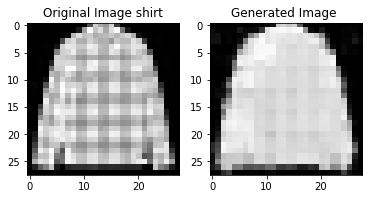

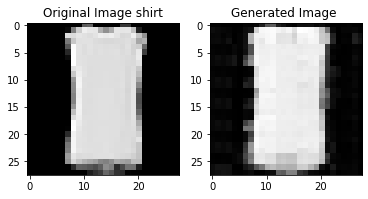

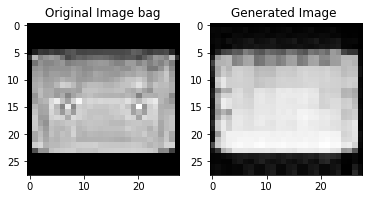

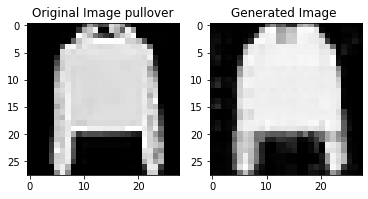

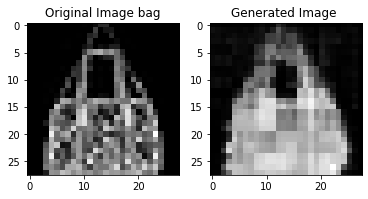

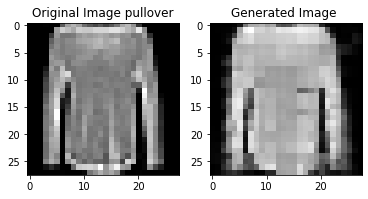

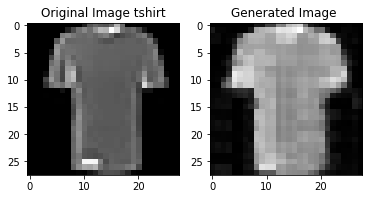

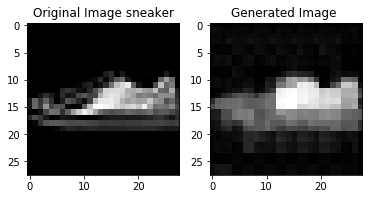

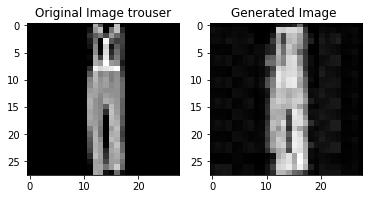

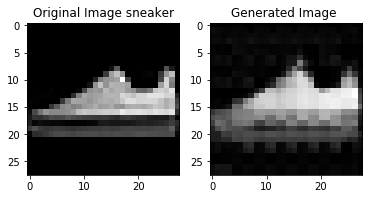

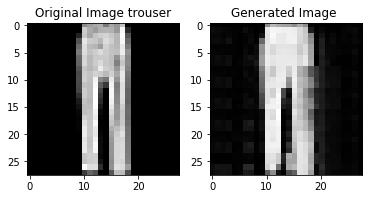

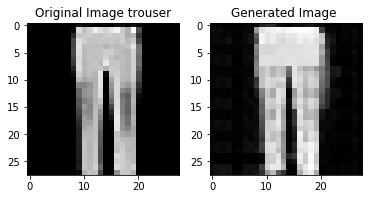

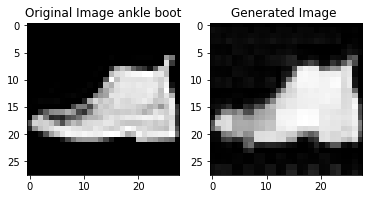

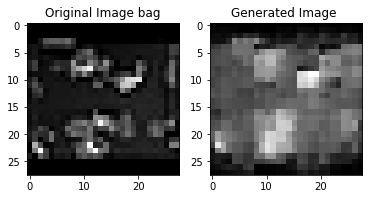

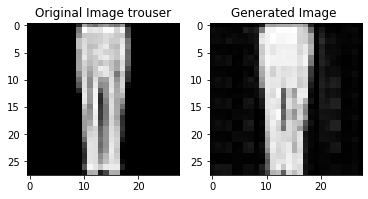

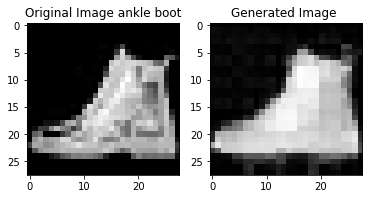

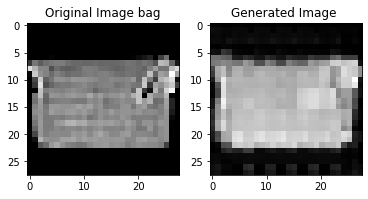

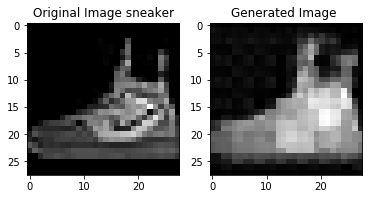

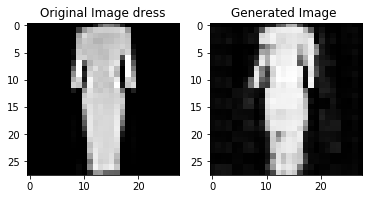

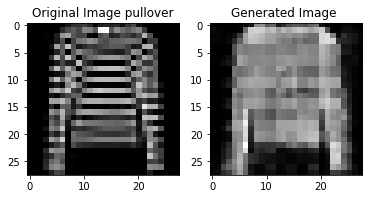

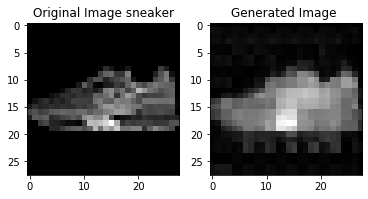

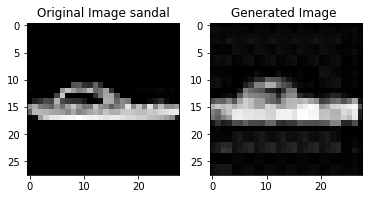

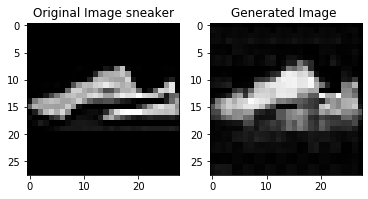

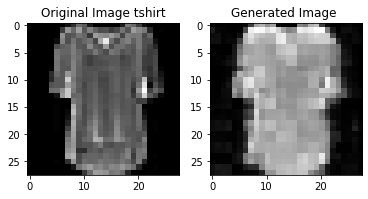

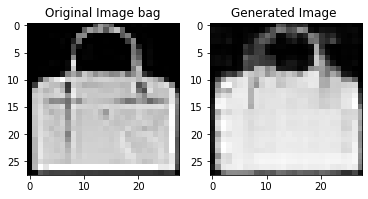

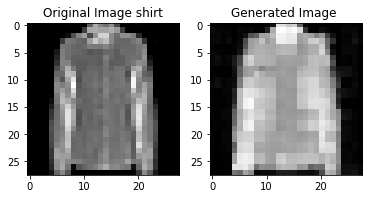

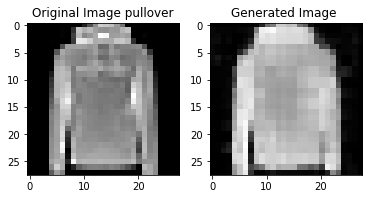

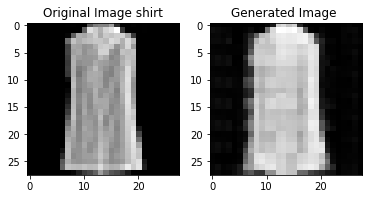

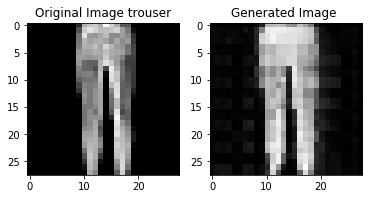

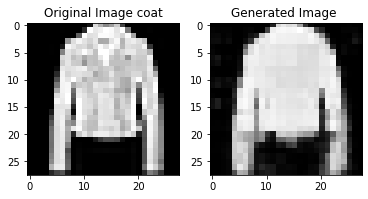

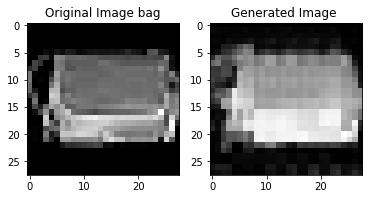

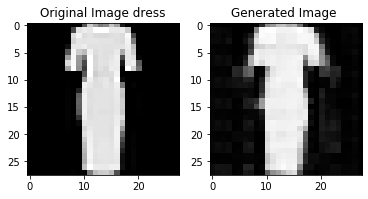

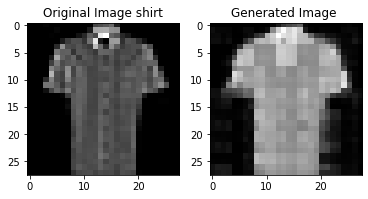

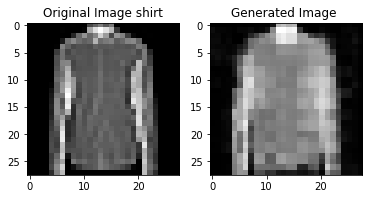

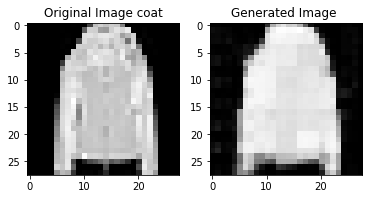

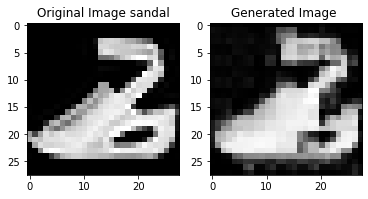

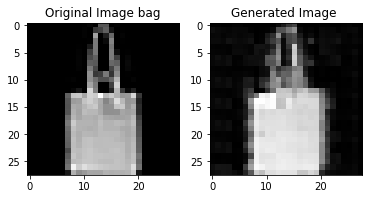

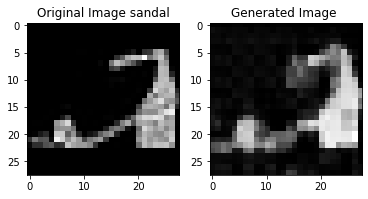

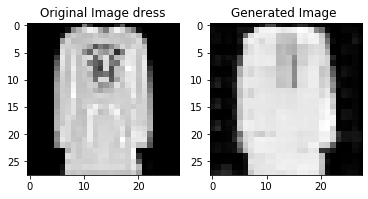

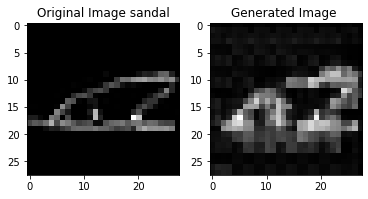

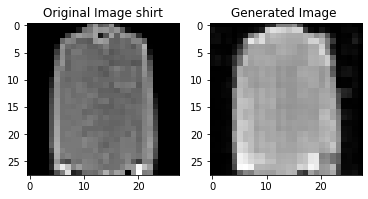

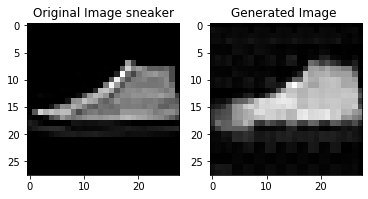

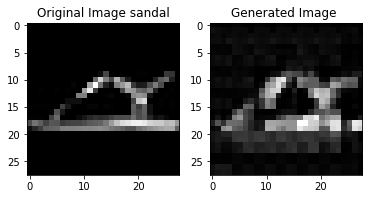

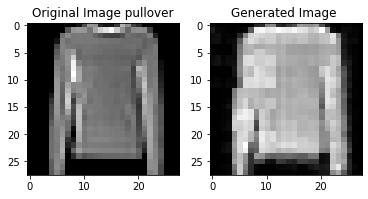

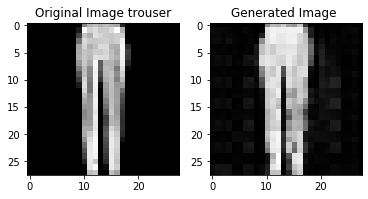

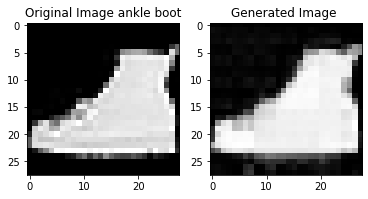

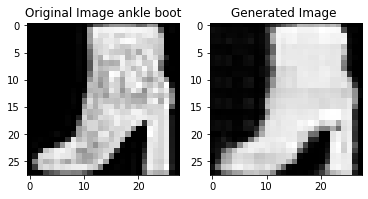

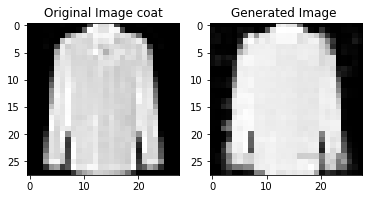

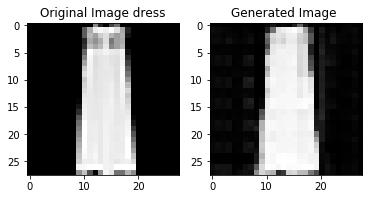

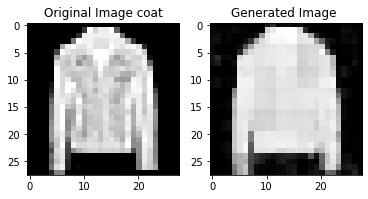

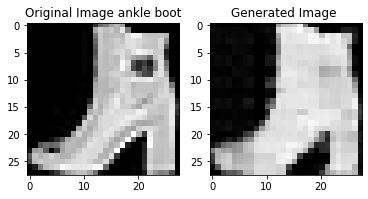

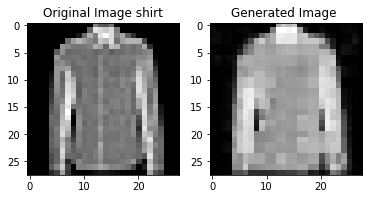

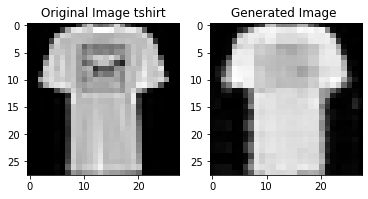

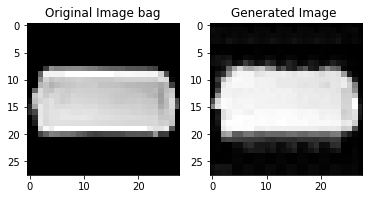

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

# Mixed model - with scaling of losses

In [0]:
def train(model,device,optimizer,epoch,trainloader,train_auto_mean,train_auto_std,train_class_mean,train_class_std):
    model.train()
    epoch_loss = 0
    correct = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        decoded,predicted = model(images)
        criterion1 = nn.MSELoss()
        criterion2 = nn.CrossEntropyLoss()
        loss1 = (criterion1(decoded,images)-train_auto_mean)/train_auto_std
        loss2 = (criterion2(predicted,labels)-train_class_mean)/train_class_std
        loss = loss1+loss2
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(trainloader.dataset),
        100. * correct / len(trainloader.dataset)))
    return epoch_loss, 100. * correct / len(trainloader.dataset)
    
def test(model,device,testloader,val_auto_mean,val_auto_std,val_class_mean,val_class_std):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            decoded, predicted = model(images)
            criterion1 = nn.MSELoss()
            criterion2 = nn.CrossEntropyLoss()
            loss1 = (criterion1(decoded,images)-val_auto_mean)/val_auto_std
            loss2 = (criterion2(predicted,labels)-val_class_mean)/val_class_std
            loss = loss1+loss2
            epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average test loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss, 100. * correct / len(testloader.dataset)

In [0]:
model = Mixed().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.01)
training_losses = []
val_losses = []
training_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    print("Epoch", epoch)
    train_loss, train_accuracy = train(model,device,optimizer,epoch,trainloader,train_mean_auto,train_std_auto,train_class_mean,train_class_std)
    val_loss, val_accuracy = test(model,device,valloader,val_mean_auto,val_std_auto,val_class_mean,val_class_std)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
    training_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average training loss: 11.9820, Training Accuracy: 31615/45000 (70%)
Average test loss: 3.8946, Testing Accuracy: 12754/15000 (85%)
Epoch 1
Average training loss: 4.0839, Training Accuracy: 36744/45000 (82%)
Average test loss: 2.3290, Testing Accuracy: 12929/15000 (86%)
Epoch 2
Average training loss: 3.1202, Training Accuracy: 37541/45000 (83%)
Average test loss: 3.1019, Testing Accuracy: 13044/15000 (87%)
Epoch 3
Average training loss: 2.1808, Training Accuracy: 38372/45000 (85%)
Average test loss: 1.0831, Testing Accuracy: 13275/15000 (88%)
Epoch 4
Average training loss: 1.8232, Training Accuracy: 38824/45000 (86%)
Average test loss: 1.6857, Testing Accuracy: 12926/15000 (86%)
Epoch 5
Average training loss: 1.9315, Training Accuracy: 38632/45000 (86%)
Average test loss: 7.1607, Testing Accuracy: 13301/15000 (89%)
Epoch 6
Average training loss: 1.3727, Training Accuracy: 39258/45000 (87%)
Average test loss: 0.4638, Testing Accuracy: 13407/15000 (89%)
Epoch 7
Average training loss: 2.0

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average test loss: 1.6814, Testing Accuracy: 8953/10000 (90%)
Lowest validation loss -0.7588531222432218


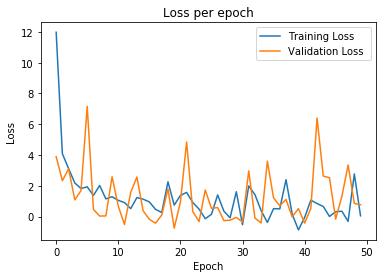

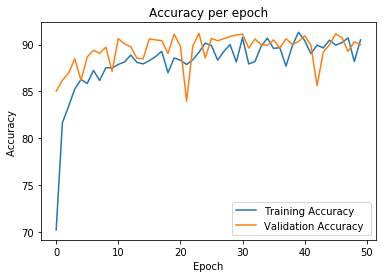

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(training_accuracies,val_accuracies,epochs,"Accuracy ")
test(model,device,testloader,val_mean_auto,val_std_auto,val_class_mean,val_class_std)
print("Lowest validation loss", min(val_losses))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


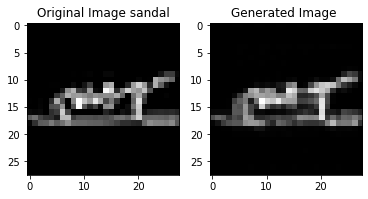

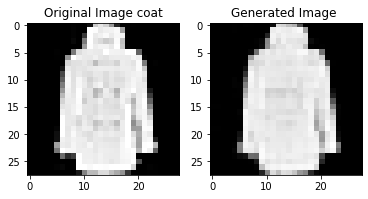

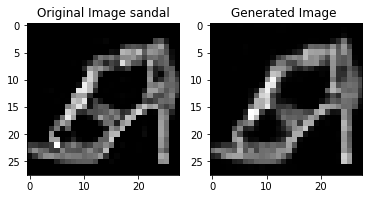

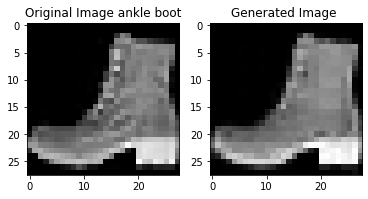

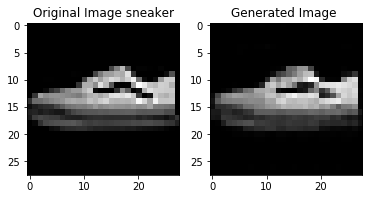

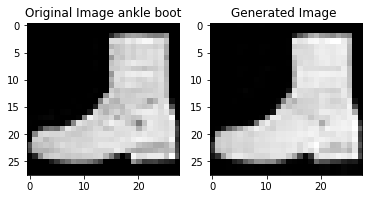

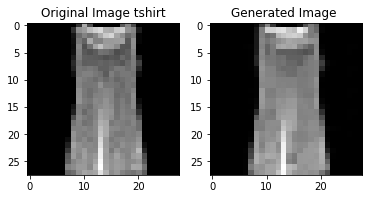

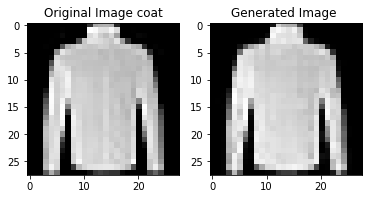

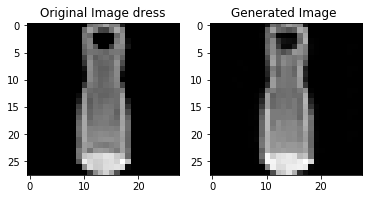

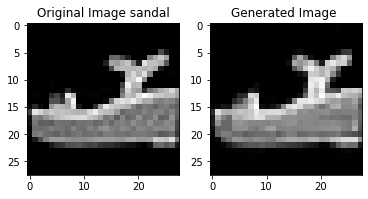

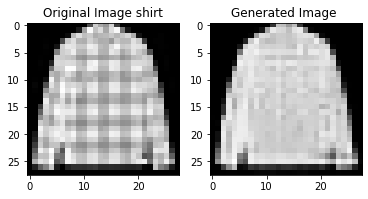

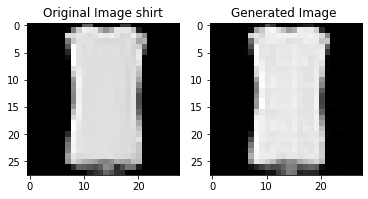

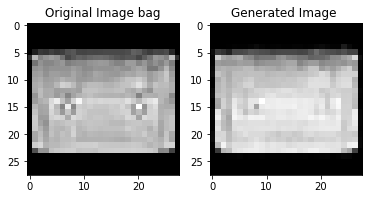

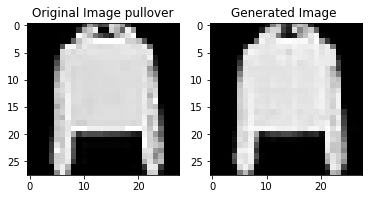

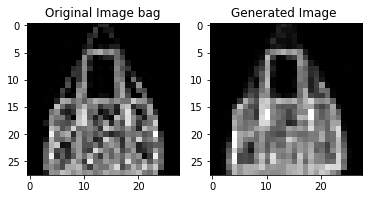

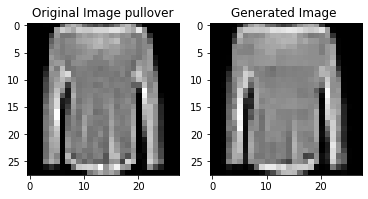

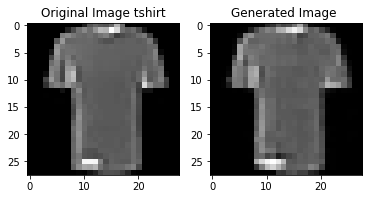

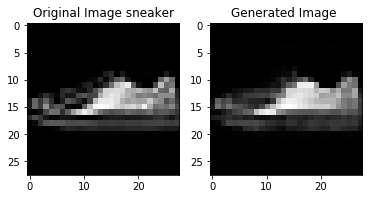

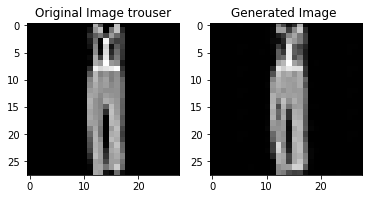

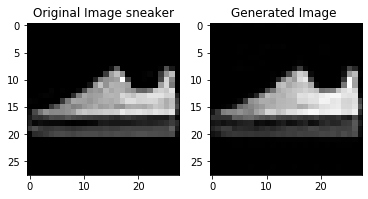

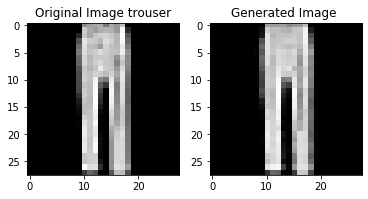

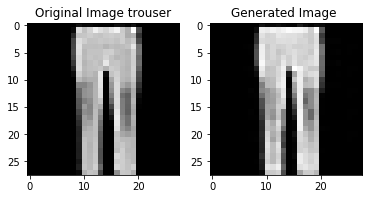

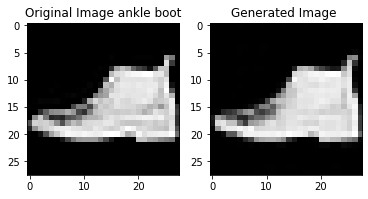

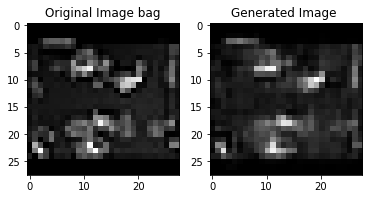

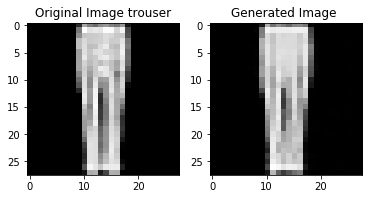

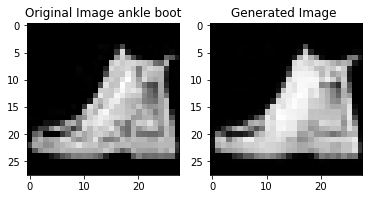

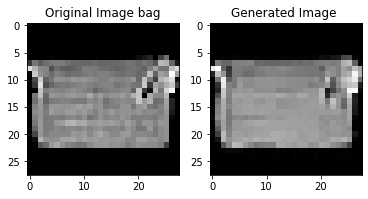

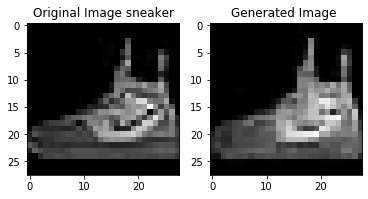

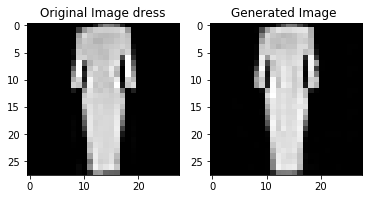

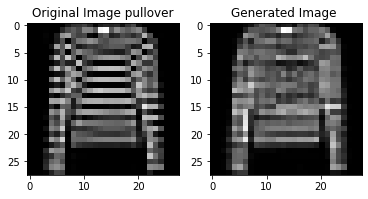

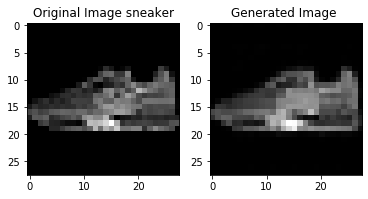

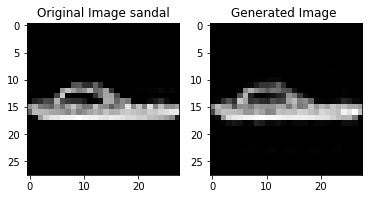

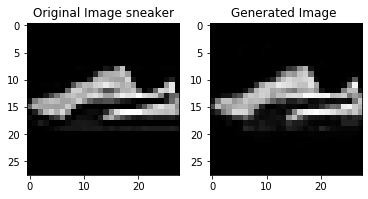

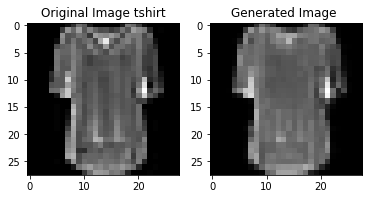

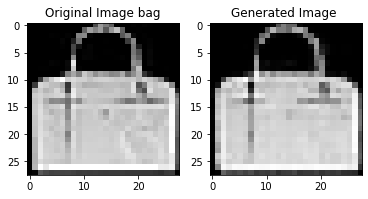

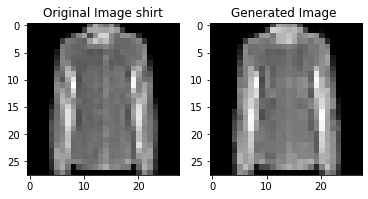

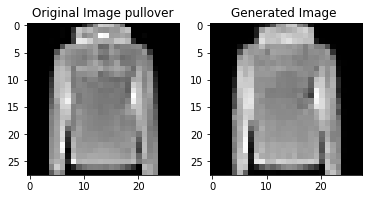

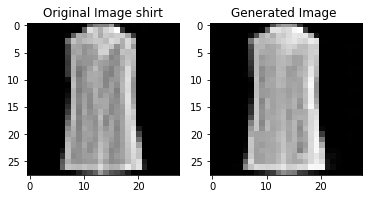

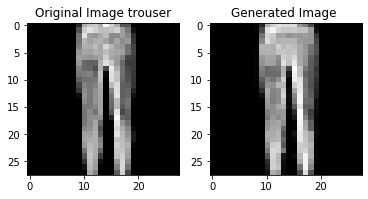

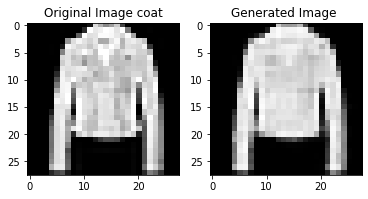

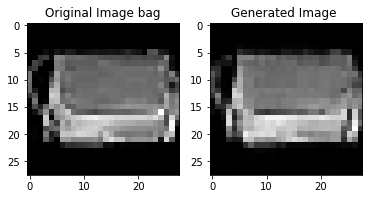

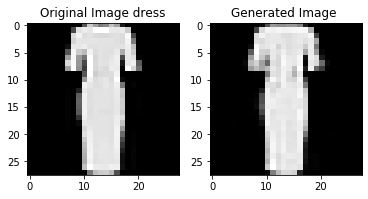

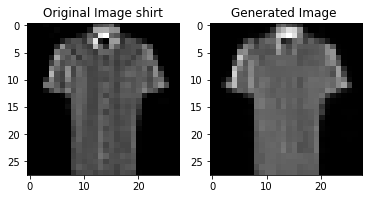

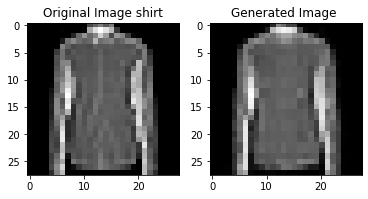

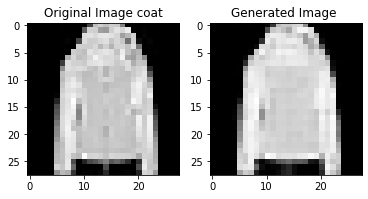

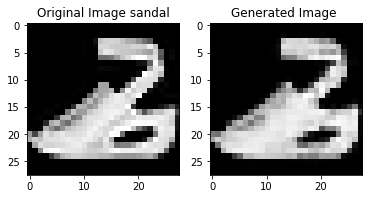

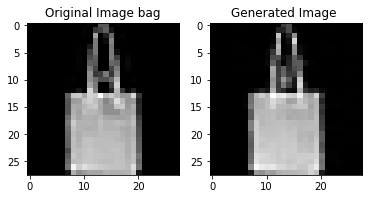

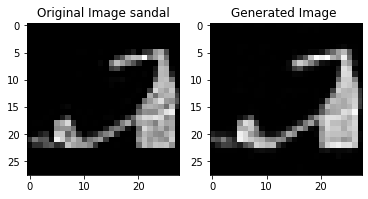

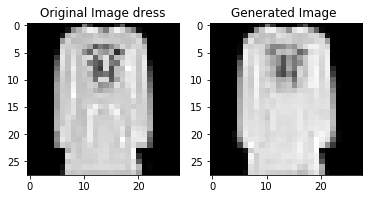

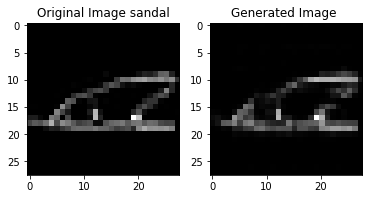

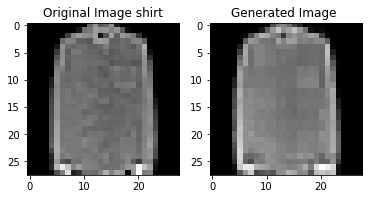

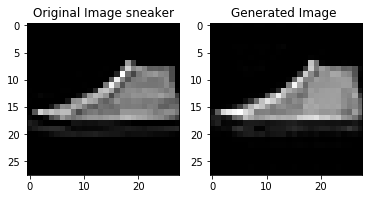

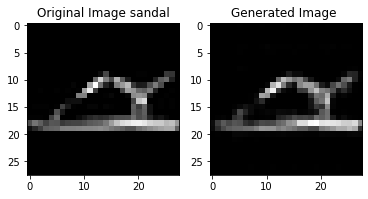

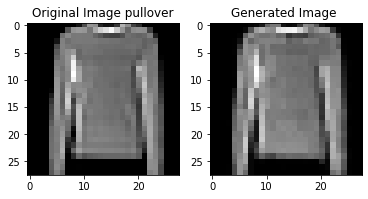

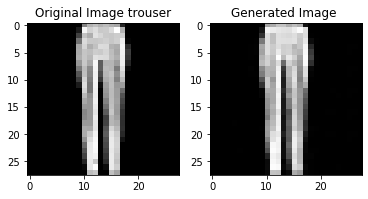

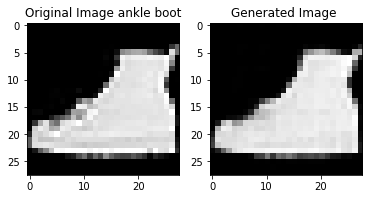

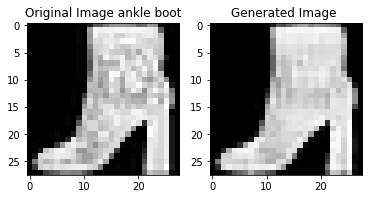

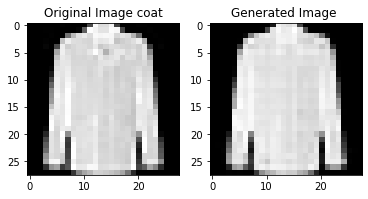

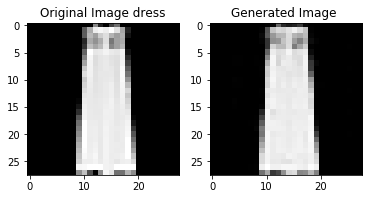

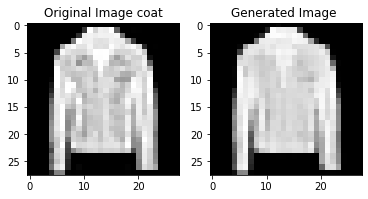

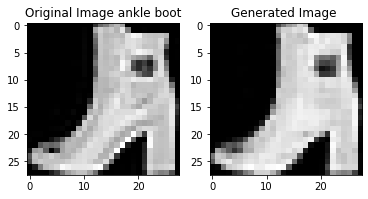

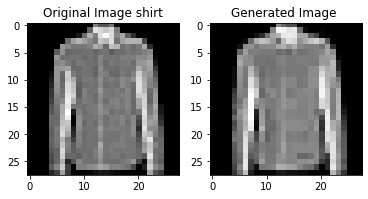

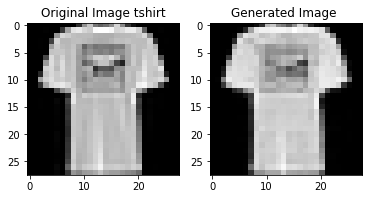

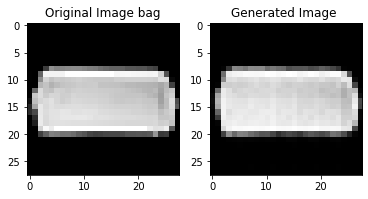

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()